In [533]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import pandas as pd
from astropy.cosmology import Planck13

In [544]:
# Load data
gkvScienceSpevObj_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/gkvScinence-SpectObj27/gkvScienceSpevObj.fits')[1].data
SDSS = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/SDSS/SDSS_DR7/SDSS_DR7.fits')[1].data
#SDSS = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/SDSS/SDSS_atlas/sdss_atlas.fits')[1].data

print('number of objects in gkvSCIENCE_raw:',len(gkvScienceSpevObj_raw))
print('number of objects in SDSS:          ',len(SDSS))

number of objects in gkvSCIENCE_raw: 425117
number of objects in SDSS:           927552


number of objects in gkvInput_raw: 2232985
number of objects in SDSS_atlas:    619730

In [535]:
# Apply masks to GAMA data
gkv_masks = (
    (gkvScienceSpevObj_raw['uberclass'] == 1)&  # galaxy
    (gkvScienceSpevObj_raw['duplicate'] != True)&
    (gkvScienceSpevObj_raw['mask'] != True)&
    (gkvScienceSpevObj_raw['starmask'] != True)&  # objects near bright stars
    #(gkvScienceSpevObj_raw['SURVEY'] == 'GAMA')&
    (gkvScienceSpevObj_raw['NQ'] > 2)
)
gkvScienceSpevObj = gkvScienceSpevObj_raw[gkv_masks]
print('number of galaxies in SCIENCE after applying the masks:', len(gkvScienceSpevObj))
print('number of objects in SCIENCE that is reduced (non-galaxies):', len(gkvScienceSpevObj_raw)-len(gkvScienceSpevObj))



# gkvScienceSpevObj = gkvScienceSpevObj_raw
# print(len(gkvScienceSpevObj))

number of galaxies in SCIENCE after applying the masks: 233833
number of objects in SCIENCE that is reduced (non-galaxies): 191284


number of galaxies in gkvInputCatv02 after applying the masks:       233833
number of objects in gkvInputCatv02 that is reduced (non-galaxies): 1999152

In [536]:
# Functions
def load_region_to_dataframe(name_of_region, MS_dict):
    df = pd.DataFrame()
    region_data = MS_dict[name_of_region]

    df['RAcen'] = region_data['RAcen'].byteswap().newbyteorder()
    df['Z'] = region_data['Z'].byteswap().newbyteorder() #using byteswap to handle the "endian" issue that was happening
    df = df[df['Z'] != -9.999]
    df['lookbacktime'] = Planck13.lookback_time(df['Z']).value

    return df

def load_region_to_dataframe_guz(name_of_region, MS_dict):
    df = pd.DataFrame()
    region_data = MS_dict[name_of_region]

    df['RAcen'] = region_data['RAcen'].byteswap().newbyteorder()
    df['Z'] = region_data['Z'].byteswap().newbyteorder()

    # Check if 'Z' column is not empty
    if not df['Z'].empty:
        df = df[df['Z'] != -9.999]
        df['lookbacktime'] = Planck13.lookback_time(df['Z']).value

    return df


In [537]:
# Define GAMA regions
regions_of_sky = {
    'G02': {'RAcen': (30.20, 38.80), 'DECcen': (-10.25, -3.72)},
    'G09': {'RAcen': (129.0, 141.0), 'DECcen': (-2.0  ,  3.0)},
    'G12': {'RAcen': (174.0, 186.0), 'DECcen': (-3.0  ,  2.0)},
    'G15': {'RAcen': (211.5, 223.5), 'DECcen': (-2.0  ,  3.0)},
    'G23': {'RAcen': (339.0, 351.0), 'DECcen': (-35.0 , -30.0)},
}

In [538]:
# GAMA MS regions

MS_regions = ['G09', 'G12', 'G15', 'G23']
MS = {region_name: regions_of_sky[region_name] for region_name in MS_regions}

# Load GAMA data for each region
MS_GAMA_objects = {region_name: gkvScienceSpevObj[(
    (gkvScienceSpevObj['RAcen'] >= region_params['RAcen'][0]) & (gkvScienceSpevObj['RAcen'] <= region_params['RAcen'][1]) &
    (gkvScienceSpevObj['DECcen'] >= region_params['DECcen'][0]) & (gkvScienceSpevObj['DECcen'] <= region_params['DECcen'][1])
)] for region_name, region_params in MS.items()}

count_MS_GAMA = sum(len(objects) for objects in MS_GAMA_objects.values())


# Load GAMA data for each region into dataframes
dataframes_GAMA = {region: load_region_to_dataframe(region, MS_GAMA_objects) for region in MS.keys()}

# Load data for all regions and combine
combined_dataframe = pd.concat(dataframes_GAMA.values())
combined_dataframe['RA_rad'] = np.deg2rad(combined_dataframe['RAcen'].values)
len_count_MS_GAMA = len(combined_dataframe)

In [539]:
# GAMA MS Plus

MS_plus_regions = ['G02', 'G09', 'G12', 'G15', 'G23']
MS_plus = {region_name: regions_of_sky[region_name] for region_name in MS_plus_regions}

# Load GAMA data for each region
MS_plus_GAMA_objects = {region_name: gkvScienceSpevObj[(
    (gkvScienceSpevObj['RAcen'] >= region_params['RAcen'][0]) & (gkvScienceSpevObj['RAcen'] <= region_params['RAcen'][1]) &
    (gkvScienceSpevObj['DECcen'] >= region_params['DECcen'][0]) & (gkvScienceSpevObj['DECcen'] <= region_params['DECcen'][1])
)] for region_name, region_params in MS_plus.items()}

count_MS_plus_GAMA = sum(len(objects) for objects in MS_plus_GAMA_objects.values())

# Load GAMA data for each region into dataframes
dataframes_plus_GAMA = {region: load_region_to_dataframe(region, MS_plus_GAMA_objects) for region in MS_plus.keys()}

# Load data for all regions and combine
combined_dataframe_plus = pd.concat(dataframes_plus_GAMA.values())
combined_dataframe_plus['RA_rad'] = np.deg2rad(combined_dataframe_plus['RAcen'].values)
len_count_MS_plus_GAMA = len(combined_dataframe_plus)

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

the lookback time t(z) at a given redshift z, where H0 is the Hubble constant, Ωm is the matter density parameter, and ΩΛ is the dark energy density parameter. The integral is evaluated from 0 to z.
since H0 is in (km/s.Mpc) and the Omegas are dimetionless, so the time t(z) is in Gyr

<font size="5">

$$ t(z) = \frac{1}{H_0} \int_0^z \frac{(1+z')}{\sqrt{\Omega_m (1+z')^3 + \Omega_\Lambda}} \, dz' $$

In [540]:
# Create dataframe for SDSS data
SDSS_objects = pd.DataFrame({
    'Z': fix_data_format(SDSS['Z']),
    'RAcen': fix_data_format(SDSS['RAcen']),
})
SDSS_objects = SDSS_objects[SDSS_objects['Z'] != -9.999]
SDSS_objects['RA_rad'] = np.deg2rad(SDSS_objects['RAcen'].values)
SDSS_objects['lookbacktime'] = Planck13.lookback_time(SDSS_objects['Z']).value
print("SDSS OBJECTS:")
print(SDSS_objects)
print('Z_max SDSS:           ',max(SDSS_objects['Z']))
print('lookbacktime_Max_SDSS:',max(SDSS_objects['lookbacktime']))

SDSS OBJECTS:
               Z       RAcen    RA_rad  lookbacktime
0       0.021275  146.714203  2.560646      0.302248
1       0.213925  146.919449  2.564228      2.658750
2       0.126554  146.859833  2.563188      1.668871
3       0.448645  146.763397  2.561504      4.804257
4       0.055988  146.963898  2.565004      0.775795
...          ...         ...       ...           ...
927547  0.033870  260.743164  4.550827      0.476817
927548  0.159622  260.800568  4.551828      2.057739
927549  0.167358  260.716003  4.550353      2.146146
927550  0.111548  260.697235  4.550025      1.486371
927551  0.223957  260.716248  4.550357      2.764950

[927552 rows x 4 columns]
Z_max SDSS:            0.6998667120933533
lookbacktime_Max_SDSS: 6.484978735783145


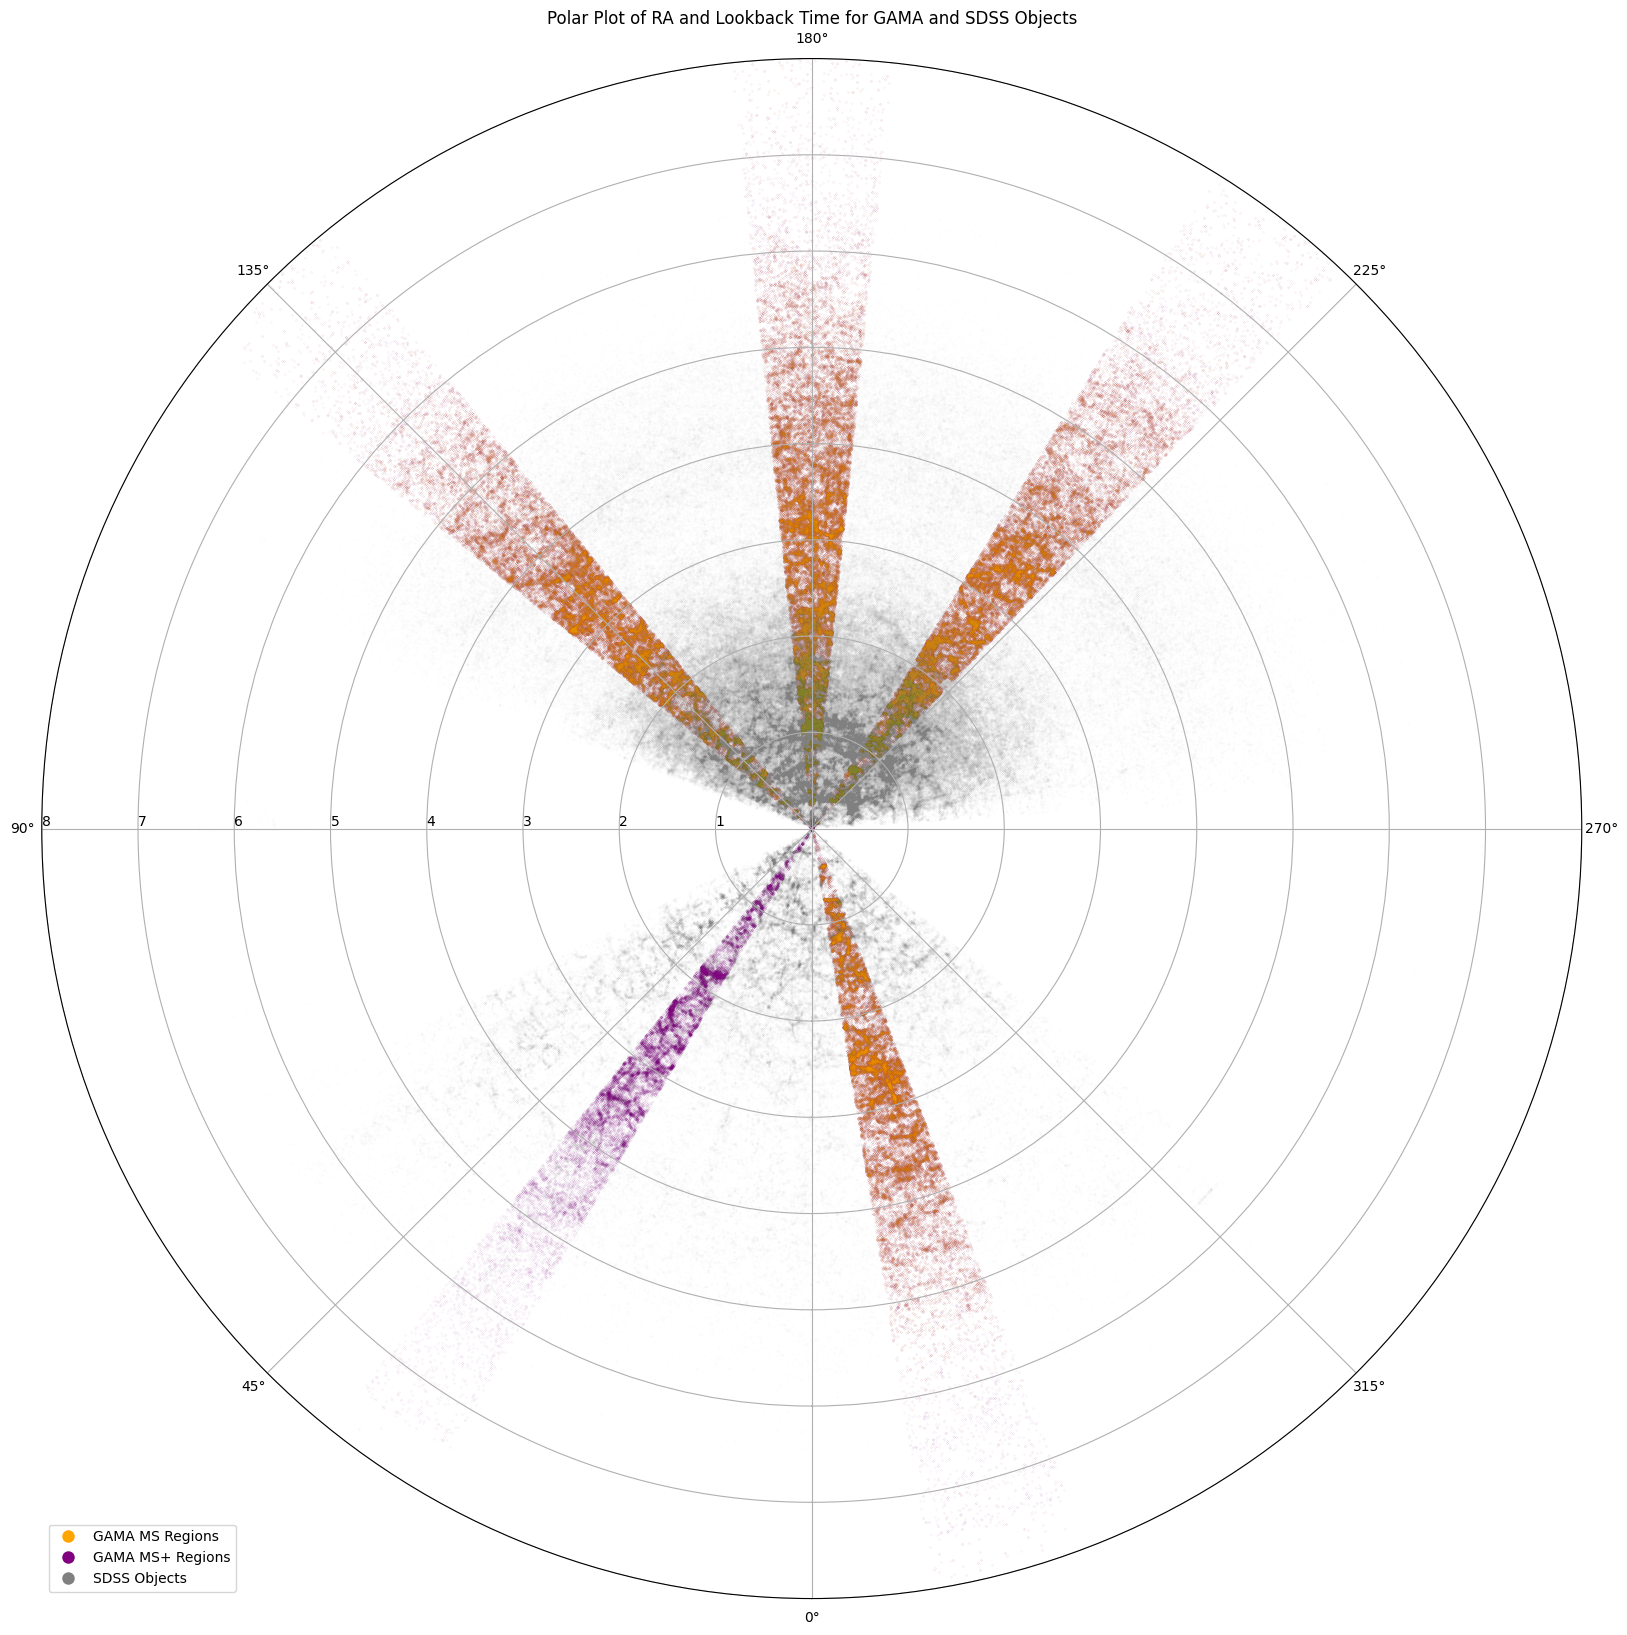

In [541]:
# Plot GAMA and SDSS data together
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(20, 20))

scatter_gama_ms_plus = ax.scatter(
    combined_dataframe_plus['RA_rad'].values,
    combined_dataframe_plus['lookbacktime'].values,
    s=0.001,
    c='purple',
    label="GAMA_MS_Plus Regions"
    )


scatter_gama_ms = ax.scatter(
    combined_dataframe['RA_rad'].values,
    combined_dataframe['lookbacktime'].values,
    s=0.001,
    c='orange',
    label="GAMA_MS Regions"
    )


scatter_sdss = ax.scatter(
    SDSS_objects['RA_rad'].values,
    SDSS_objects['lookbacktime'].values,
    s=0.0001,
    c='gray',
    label="SDSS Objects"
    )


legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label="GAMA MS Regions"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label="GAMA MS+ Regions"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label="SDSS Objects"),
]

ax.legend(handles=legend_handles)

ax.set_theta_direction(-1)
ax.set_theta_zero_location("S")
ax.set_rlabel_position(90)
ax.set_rmax(8)
ax.set_rmin(0)
plt.title("Polar Plot of RA and Lookback Time for GAMA and SDSS Objects")
plt.show()


FIG 2, LOWER PLOT :

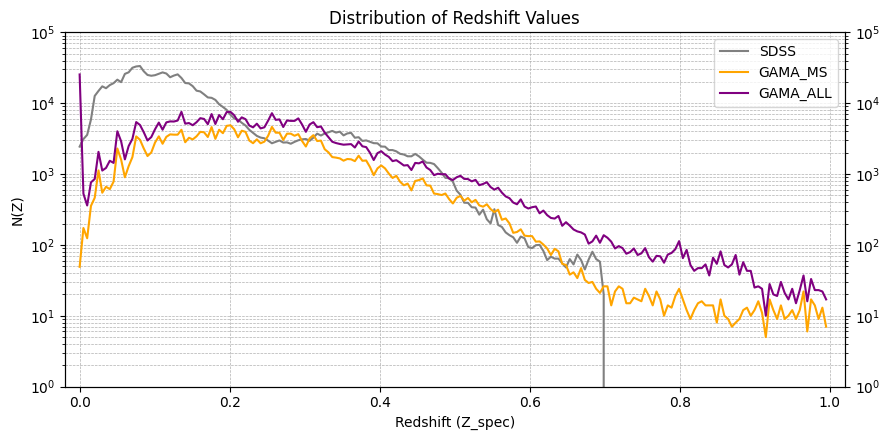

In [542]:
# Lower PLOT

Z_SDSS = {'SDSS': fix_data_format(SDSS_objects[SDSS_objects['Z'] >= 0]['Z'].values)}
# Z_SDSS = {'SDSS': SDSS_test[SDSS_test['Z'] >= 0]['Z']}
Z_GAMA_MS = {'GAMA_MS': combined_dataframe[combined_dataframe['Z'] >= 0]['Z']}
Z_GAMA_Plus = {'GAMA_Plus': combined_dataframe_plus[combined_dataframe_plus['Z'] >= 0]['Z']} #change to gama all
Z_GAMA_ALL = {'GAMA_ALL': gkvScienceSpevObj_raw[gkvScienceSpevObj_raw['Z'] >= 0]['Z']}

fig, ax = plt.subplots(figsize=(9, 4.5))

for dataset, color in zip([ Z_SDSS, Z_GAMA_MS, Z_GAMA_ALL], ['gray', 'orange', 'purple']):
    for label, Z in dataset.items():
        hist, edges = np.histogram(Z, bins=np.linspace(0, 1, 200), range=(0, 1))
        ax.plot(edges[:-1], hist, color=color, label=label)

ax.set_xlabel('Redshift (Z_spec)')
ax.set_ylabel('N(Z)')
ax.set_title('Distribution of Redshift Values')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(1, 10**5)

# Create a twin y-axis
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_ylim(ax.get_ylim())

plt.tight_layout()
plt.show()
